# RAG over complex Documents


## Setting
 - Auto Reload
 - path for utils

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys, os
module_path = "../../.."
sys.path.append(os.path.abspath(module_path))

## 1. Creatr Bedrock client

In [3]:
import json
import boto3
from pprint import pprint
from termcolor import colored
from utils import bedrock, print_ww
from utils.bedrock import bedrock_info

### ---- ⚠️ Un-comment and edit the below lines as needed for your AWS setup ⚠️ ----
- os.environ["AWS_DEFAULT_REGION"] = "<REGION_NAME>"  # E.g. "us-east-1"
- os.environ["AWS_PROFILE"] = "<YOUR_PROFILE>"
- os.environ["BEDROCK_ASSUME_ROLE"] = "<YOUR_ROLE_ARN>"  # E.g. "arn:aws:..."
- os.environ["BEDROCK_ENDPOINT_URL"] = "<YOUR_ENDPOINT_URL>"  # E.g. "https://..."

In [4]:
boto3_bedrock = bedrock.get_bedrock_client(
    assumed_role=os.environ.get("BEDROCK_ASSUME_ROLE", None),
    endpoint_url=os.environ.get("BEDROCK_ENDPOINT_URL", None),
    region=os.environ.get("AWS_DEFAULT_REGION", None),
)

print (colored("\n== FM lists ==", "green"))
pprint (bedrock_info.get_list_fm_models(verbose=False))

Create new client
  Using region: None
  Using profile: None
boto3 Bedrock client successfully created!
bedrock-runtime(https://bedrock-runtime.us-east-1.amazonaws.com)

== FM lists ==
{'Claude-Instant-V1': 'anthropic.claude-instant-v1',
 'Claude-V1': 'anthropic.claude-v1',
 'Claude-V2': 'anthropic.claude-v2',
 'Claude-V2-1': 'anthropic.claude-v2:1',
 'Claude-V3-Haiku': 'anthropic.claude-3-haiku-20240307-v1:0',
 'Claude-V3-Sonnet': 'anthropic.claude-3-sonnet-20240229-v1:0',
 'Cohere-Embeddings-En': 'cohere.embed-english-v3',
 'Cohere-Embeddings-Multilingual': 'cohere.embed-multilingual-v3',
 'Command': 'cohere.command-text-v14',
 'Command-Light': 'cohere.command-light-text-v14',
 'Jurassic-2-Mid': 'ai21.j2-mid-v1',
 'Jurassic-2-Ultra': 'ai21.j2-ultra-v1',
 'Llama2-13b-Chat': 'meta.llama2-13b-chat-v1',
 'Titan-Embeddings-G1': 'amazon.titan-embed-text-v1',
 'Titan-Text-G1': 'amazon.titan-text-express-v1',
 'Titan-Text-G1-Light': 'amazon.titan-text-lite-v1'}


## 2. Titan Embedding 및 LLM 인 Claude-v3-sonnet 모델 로딩

### LLM 로딩 (Claude-v3-sonnet)

In [5]:
from langchain_community.chat_models import BedrockChat
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

In [6]:
llm_text = BedrockChat(
    model_id=bedrock_info.get_model_id(model_name="Claude-V3-Sonnet"),
    client=boto3_bedrock,
    streaming=True,
    callbacks=[StreamingStdOutCallbackHandler()],
    model_kwargs={
        "max_tokens": 1024,
        "stop_sequences": ["\n\nHuman"],
        # "temperature": 0,
        # "top_k": 350,
        # "top_p": 0.999
    }
)
llm_text

BedrockChat(client=<botocore.client.BedrockRuntime object at 0x7f3753b53670>, model_id='anthropic.claude-3-sonnet-20240229-v1:0', model_kwargs={'max_tokens': 1024, 'stop_sequences': ['\n\nHuman']}, streaming=True, callbacks=[<langchain_core.callbacks.streaming_stdout.StreamingStdOutCallbackHandler object at 0x7f375315abf0>])

### Embedding 모델 선택

In [7]:
from langchain.embeddings import BedrockEmbeddings

In [8]:
llm_emb = BedrockEmbeddings(
    client=boto3_bedrock,
    model_id=bedrock_info.get_model_id(model_name="Titan-Embeddings-G1")
)
dimension = 1536
print("Bedrock Embeddings Model Loaded")

Bedrock Embeddings Model Loaded


## 3. Depoly ReRanker model (if needed)

In [9]:
import json
import sagemaker
from sagemaker.huggingface import HuggingFaceModel

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [10]:
depoly = False

In [11]:
if depoly:

    try:
        role = sagemaker.get_execution_role()
    except ValueError:
        iam = boto3.client('iam')
        role = iam.get_role(RoleName='sagemaker_execution_role')['Role']['Arn']

    # Hub Model configuration. https://huggingface.co/models
    hub = {
        'HF_MODEL_ID':'Dongjin-kr/ko-reranker',
        'HF_TASK':'text-classification'
    }

    # create Hugging Face Model Class
    huggingface_model = HuggingFaceModel(
        transformers_version='4.26.0',
        pytorch_version='1.13.1',
        py_version='py39',
        env=hub,
        role=role, 
    )

    # deploy model to SageMaker Inference
    predictor = huggingface_model.deploy(
        initial_instance_count=1, # number of instances
        instance_type='ml.g5.xlarge' # instance type
    )

    print(f'Accept: {predictor.accept}')
    print(f'ContentType: {predictor.content_type}')
    print(f'Endpoint: {predictor.endpoint}')

#### Save reranker endpoint to Parameter Store

In [12]:
if depoly:

    import boto3
    from utils.ssm import parameter_store

    region=boto3.Session().region_name
    pm = parameter_store(region)

    pm.put_params(
        key="reranker_endpoint",
        value=f'{predictor.endpoint}',
        overwrite=True,
        enc=False
    )

## 4. Invocation (prediction)

In [13]:
from utils.ssm import parameter_store

In [14]:
region=boto3.Session().region_name
pm = parameter_store(region)

In [15]:
runtime_client = boto3.Session().client('sagemaker-runtime')
print (f'runtime_client: {runtime_client}')

runtime_client: <botocore.client.SageMakerRuntime object at 0x7f3737b28520>


In [16]:
endpoint_name = pm.get_params(
    key="reranker_endpoint",
    enc=False
)
deserializer = "application/json"

In [17]:
payload = json.dumps(
    {
        "inputs": [
            {"text": "I hate you", "text_pair": "I don't like you"},
            {"text": "He hates you", "text_pair": "He like you"}
        ]
    }
)

In [18]:
payload = json.dumps(
    {
        "inputs": [
            {"text": "나는 너를 사랑하지 않아", "text_pair": "나는 너를 좋아하지 않아"},
            {"text": "그는 너를 싫어해", "text_pair": "그는 너를 좋아해"}
        ]
    }
)

In [19]:
%%time
response = runtime_client.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType="application/json",
    Accept=deserializer,
    Body=payload
)
## deserialization
out = json.loads(response['Body'].read().decode()) ## for json
print (f'Response: {out}')

Response: [{'label': 'LABEL_0', 'score': 0.9984032511711121}, {'label': 'LABEL_0', 'score': 0.004707992542535067}]
CPU times: user 12.8 ms, sys: 1.13 ms, total: 13.9 ms
Wall time: 90.2 ms


## 5. LangChainOpenSearch VectorStore 정의
### 선수 조건
- 01_preprocess_docs/02_load_docs_opensearch.ipynb를 통해서 OpenSearch Index 가 생성이 되어 있어야 합니다.
#### [중요] 아래에 aws parameter store 에 아래 인증정보가 먼저 입력되어 있어야 합니다.
- 01_preprocess_docs/01_parameter_store_example.ipynb 참고

In [20]:
import boto3
from utils.ssm import parameter_store

In [21]:
region=boto3.Session().region_name
pm = parameter_store(region)

In [22]:
opensearch_domain_endpoint = pm.get_params(
    key="opensearch_domain_endpoint",
    enc=False
)

opensearch_user_id = pm.get_params(
    key="opensearch_user_id",
    enc=False
)

opensearch_user_password = pm.get_params(
    key="opensearch_user_password",
    enc=True
)

In [23]:
opensearch_domain_endpoint = opensearch_domain_endpoint
rag_user_name = opensearch_user_id
rag_user_password = opensearch_user_password

http_auth = (rag_user_name, rag_user_password) # Master username, Master password

### Index 이름 셋팅
- 이전 노트북 01_preprocess_docs/02_load_docs_opensearch.ipynb를 통해서 생성된 OpenSearch Index name 입력

In [26]:
index_name = opensearch_user_password = pm.get_params(
    key="opensearch_index_name",
    enc=True
)

print (f'index_name: {index_name}')

index_name: summit-workshop-index-unstructured-pymupdf-llama


In [63]:
index_name = "summit-workshop-index"

### OpenSearch Client 생성

In [64]:
from utils.opensearch import opensearch_utils

In [65]:
aws_region = os.environ.get("AWS_DEFAULT_REGION", None)
os_client = opensearch_utils.create_aws_opensearch_client(
    aws_region,
    opensearch_domain_endpoint,
    http_auth
)

## 4. Question Answering
- [BedrockChat with claude3](https://medium.com/@dminhk/building-with-anthropics-claude-3-on-amazon-bedrock-and-langchain-%EF%B8%8F-2b842f9c0ca8)

In [66]:
from utils.rag import qa_chain
from utils.rag import prompt_repo, show_context_used
from langchain.callbacks.tracers import ConsoleCallbackHandler
from utils.rag import retriever_utils, OpenSearchHybridSearchRetriever

### Retriever 정의

In [77]:
opensearch_hybrid_retriever = OpenSearchHybridSearchRetriever(
    os_client=os_client,
    index_name=index_name,
    llm_text=llm_text, # llm for query augmentation in both rag_fusion and HyDE
    llm_emb=llm_emb, # Used in semantic search based on opensearch 

    # hybird-search debugger
    #hybrid_search_debugger = "semantic", #[semantic, lexical, None]
    
    # option for lexical
    minimum_should_match=0,
    filter=[],

    # option for search
    fusion_algorithm="RRF", # ["RRF", "simple_weighted"], rank fusion 방식 정의
    ensemble_weights=[.51, .49], # [for semantic, for lexical], Semantic, Lexical search 결과에 대한 최종 반영 비율 정의
    reranker=True, # enable reranker with reranker model
    reranker_endpoint_name=endpoint_name, # endpoint name for reranking model
    parent_document=True, # enable parent document
    
    # hybird-search debugger
    hybrid_search_debugger = "semantic", #[semantic, lexical, None]

    rag_fusion=False, # enable rag_fusion
    query_augmentation_size=2, # query_augmentation_size in rag_fusion
    #hyde=True, # enable hyde
    #hyde_query=["web_search"], # query type in hyde 
    
    # option for complex documents consisting of text, table and image
    complex_doc=True,
    
    # option for async search
    async_mode=False,

    # option for output
    k=5, # 최종 Document 수 정의
    verbose=True,
)

### QA chain 정의

In [78]:
system_prompt = prompt_repo.get_system_prompt()

In [79]:
qa = qa_chain(
    llm_text=llm_text,
    retriever=opensearch_hybrid_retriever,
    system_prompt=system_prompt,
    return_context=True,
    verbose=False
)


[Exeeds ReRanker token limit] Number of chunk_docs after split and chunking= 2

child_search_results [(Document(page_content='이 이미지는 상록초등학교의 로고와 웹사이트 주소가 표시되어 있습니다. 로고에는 녹색과 노란색 원이 있고, 가운데에 상록이라는 글자가 있습니다. 웹사이트 주소는 http://sangrok-asn.es.kr입니다. 상단에는 "바른 인성, 건강한 감성, 즐거운 배움으로 미래를 가꾸는"이라는 문구가 적혀 있습니다.', metadata={'img_path': './fig/figure-32-69.jpg', 'category': 'Image', 'image_base64': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAFrBTADASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJB

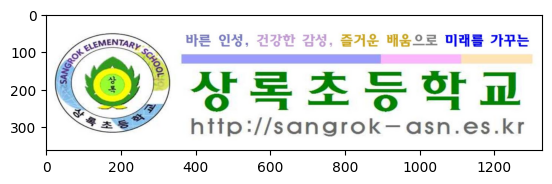

이 이미지는 상록초등학교의 로고와 웹사이트 주소가 표시되어 있습니다. 로고에는 녹색과 노란색 원이 있고, 가운데에 상록이라는 글자가 있습니다. 웹사이트 주소는
http://sangrok-asn.es.kr입니다. 상단에는 "바른 인성, 건강한 감성, 즐거운 배움으로 미래를 가꾸는"이라는 문구가 적혀 있습니다.
metadata:
 {'img_path': './fig/figure-32-69.jpg', 'category': 'Image', 'image_base64': '', 'family_tree':
'parent_image', 'parent_id': 'NA', 'id': 'd9ad25cc-78ac-43f3-80f9-f12dbbf8317b', 'origin_image': '',
'orig_elements': ''}

-----------------------------------------------
2. Category: Image, Chunk: 128 Characters
-----------------------------------------------


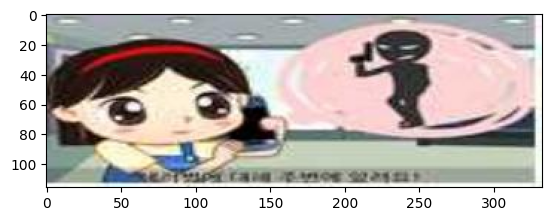

이미지에는 큰 눈과 검은 머리를 가진 만화 소녀 캐릭터와 프라이팬에 구운 듯한 까만 생선 실루엣이 있습니다. 이것은 아마도 생선구이 요리와 관련된 광고나 메뉴를 나타내는 것
같습니다. 전반적인 분위기는 밝고 친근한 느낌을 줍니다.
metadata:
 {'img_path': './fig/table-12.jpg', 'category': 'Image', 'image_base64': '', 'family_tree':
'parent_image', 'parent_id': 'NA', 'id': '27ed0303-6bf9-4dc2-9ecb-d74cbd589f4f', 'origin_image': '',
'orig_elements': ''}

-----------------------------------------------
3. Category: Image, Chunk: 149 Characters
-----------------------------------------------


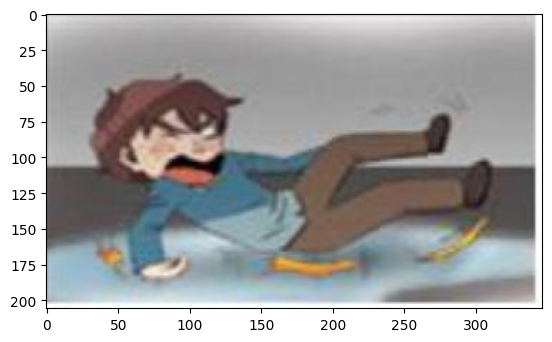

주어진 이미지는 애니메이션 캐릭터가 바닥에 미끄러지고 있는 장면을 보여줍니다. 캐릭터는 빨간 머리를 가지고 있으며 파란 셔츠와 갈색 바지를 입고 있습니다. 바닥에는 노란색 바나나
껍질이 있어 미끄러진 원인을 알 수 있습니다. 이 장면은 개그 상황을 연출하고 있습니다.
metadata:
 {'img_path': './fig/figure-16-28.jpg', 'category': 'Image', 'image_base64': '', 'family_tree':
'parent_image', 'parent_id': 'NA', 'id': 'd435b6d3-a280-438a-9ec7-7b25b12348ac', 'origin_image': '',
'orig_elements': ''}

-----------------------------------------------
4. Category: Image, Chunk: 153 Characters
-----------------------------------------------


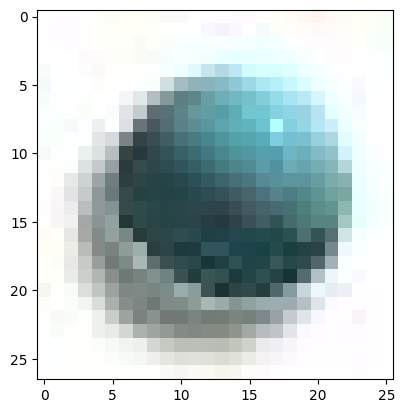

주어진 이미지는 푸른색 바다 물결과 하늘이 어우러진 유리구슬 모양의 아름다운 풍경사진입니다. 유리구슬의 표면에는 바다와 하늘이 왜곡되어 반사되어 있어 독특한 시각적 효과를
자아냅니다. 전체적으로 자연의 아름다움과 유리구슬의 환상적인 분위기가 잘 어우러진 예술적인 사진입니다.
metadata:
 {'img_path': './fig/figure-15-24.jpg', 'category': 'Image', 'image_base64': '', 'family_tree':
'parent_image', 'parent_id': 'NA', 'id': '8efbda2f-21d9-4e97-9684-86d4b18b1c8f', 'origin_image': '',
'orig_elements': ''}

-----------------------------------------------
5. Category: Image, Chunk: 197 Characters
-----------------------------------------------


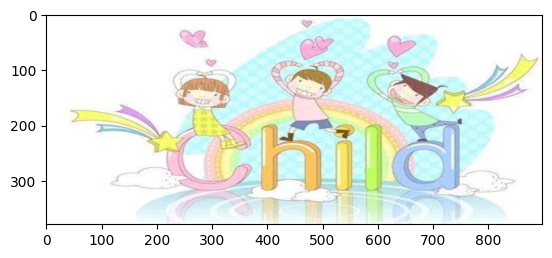

이미지는 귀여운 아이 삽화로, 무지개와 구름 위에서 행복한 모습의 세 명의 아이들이 있습니다. 아이들은 공주 모자를 쓰고 있으며, 핑크색과 하늘색, 노란색 리본 옷을 입고
있습니다. 여러 개의 작은 하트 모양들이 배경을 장식하고 있으며, 전체적으로 밝고 사랑스러운 분위기를 자아냅니다. 이 그림은 아동 관련 콘텐츠나 제품을 위한 아트워크일 것
같습니다.
metadata:
 {'img_path': './fig/table-14.jpg', 'category': 'Image', 'image_base64': '', 'family_tree':
'parent_image', 'parent_id': 'NA', 'id': '1df5af6d-6095-4922-a395-068750fae89c', 'origin_image': '',
'orig_elements': ''}


In [80]:
#query = "감독계획수립 후 현장감독에서 법 위반을 하면 이후 프로세스는?" ## Image 30
#query = "안전보건표지에서 지시표지의 종류와 용도는?" ## Table 8
#query = "건강진단 순서를 알려줘" ## Diagram 15

#query = "수익률 그래프 설명해줘"
#query = "만기가격이 기준가격의 100% 미만일 때 만기상환금액 계산하는 방법 알려줘"
#query = "전년 동기 현금 예치금 구성비 알려줘"
#query = "자산총계 금액 알려줘"
#query = "대출채권 금액은?"

#query = "대출채권의 전년동기에 해당하는 구성비는 얼마입니까?"
#query = "당기손익-공정가치측정유가증권 전년동기의 구성비는?"

query = "재난 발생 시 대처사항은?"
query = "학교폭력 처리 과정은?"
#query = "감염병의 종류와 경로는?"
query = "홍역에 대한 백신 이름은?"
#query = "MMR 2차의 예방접종 시기는?"
#query = "교육목표는?"
#query = "만기상환금액 알려줘"
query = "asdf"

response, contexts = qa.invoke(
    query = query,
    verbose=False
)

show_context_used(contexts)

### Parameter updates

In [ ]:
opensearch_hybrid_retriever.update_search_params(
    k=7,
    minimum_should_match=0,
    
    # hybird-search debugger
    hybrid_search_debugger = "None", #[lexical, semantic, None]
    
    # filter=[
    #     {'term': {'metadata.family_tree': 'child'}},
    # ],
    
    reranker=True, # enable reranker with reranker model
    reranker_endpoint_name=endpoint_name, # endpoint name for reranking model
    parent_document=True, # enable parent document
    rag_fusion=False, # enable rag_fusion
    #query_augmentation_size=2, # query_augmentation_size in rag_fusion
    #hyde=False, # enable hyde
    #hyde_query=["web_search"], # query type in hyde 
    
    # option for complex documents consisting of text, table and image
    complex_doc=True, # False 이면, invocation시 text만 넣는다. 단, 
    
    ensemble_weights=[0.51, 0.49], #semantic, lexical
    verbose=True
)

In [71]:
#query = "감독계획수립 후 현장감독에서 법 위반을 하면 이후 프로세스는?" ## Image 30
#query = "안전보건표지에서 지시표지의 종류와 용도는?" ## Table 8
#query = "건강진단 순서를 알려줘" ## Diagram 15

##
query = "학기 초에 어린이 납치 예방 방법은?" # semantic o, lexical x
query = "차 흡연 옷. 벽면에 붙은 연기로 인한 피해?" # semantic o, lexical x
query = "교육목표는?"
#query = "수익률 그래프 설명해줘"
query = "감염병의 종류와 경로는?"
query = "학교폭력 유형의 개수와 종류 알려줘"
query = "응급처치 방법에 대해서 알려줘"
query = "차 밑에서 물건을 꺼내는 아이는 누가 도와줘야 해?"
query = "공사장 근처에서 노는 아이는 누가 도와줘야 해?"
#query = "중지된 경우 이체"


In [72]:
response, contexts = qa.invoke(
    query = query,
    verbose=False
)


[Exeeds ReRanker token limit] Number of chunk_docs after split and chunking= 2


[Exeeds ReRanker token limit] Number of chunk_docs after split and chunking= 2


[Exeeds ReRanker token limit] Number of chunk_docs after split and chunking= 3


[Exeeds ReRanker token limit] Number of chunk_docs after split and chunking= 2

child_search_results [(Document(page_content='19 교육활동 참여자 안전교육(녹색, 폴리스) 교사 이○혜 1.1. 목적목적 어린이들의 통학로 안전성을 확보하고, 안전하게 등하교 할 수 있도록 도와주며, 아동 대상 범죄 및 학 교 주변에서 자주 발생하는 학교폭력과 유해환경에서 어린이들을 안전하게 보호하기 위함임. 2. 다양한 발생 사례 2. 다양한 발생 사례 가. 스쿨존 내 학생 교통사고 사례 : 아이들은 잘 뛰어다녀요 r\\/\\QU CICRONCORES . 교 ① 무단횡단을 하는 어른을 보고 따라하는 경우 ② 초록불이 들어오자마자 갑자기 뛰어드는 경우 ③ 인도가 없는 이면도로를 지다가는 경우 ④ 횡단보도 앞에 주‧정차된 차 앞을 지나가는 경우 ⑤ 통학버스 또는 부모님 차량에서 내려 급하게 횡단보도를 건너가는 경우 보 요 . 아 험 례 : 고 는 나. 학교 교육활동 중 위험 사례 : 아이들은 몸집이 작아 잘 안보여요 ① 차도로 굴러가는 공을 쫒아가는 아이 ▶ 어른의 도움을 받도록 함. ② 차 밑에서 공(물건)을 빼고 있는 아이 ▶ 어른의 도움을 받도록 함. ③ 차 뒤에서 놀고 있는 아이 ▶ 위험한 장소에서 놀지 않도록 함. ④ 공사장 옆에서 놀고 있는 아이 ▶ 위험한 장소에서 놀지 않도록 함. ※ 사고 발생 시 이렇게 대처해주세요 →119 신고 및 사고 2

In [ ]:
print("##################################")
print("query: ", query)
print("##################################")

print (colored("\n\n### Answer ###", "blue"))
print_ww(response)


print (colored("\n\n### Contexts ###", "green"))
show_context_used(contexts, limit=10)